In [19]:
from fastai.vision.all import *
path = Path('data')

In [17]:
from ddgs import DDGS # Uses the updated package name
import time
from ddgs.exceptions import RatelimitException

# --- Configuration ---
target_count = 100   
pause_time = 5.0 
# ---------------------

# map folder names to search queries
searches = {
    'toilet': 'bathroom with toilet photo',
    'no-toilet': 'bathroom sink and shower only interior',
    'bathroom': 'hotel bathroom' #for manual filtering into the 2 above
}

print("Starting image download process with DuckDuckGo...")

for folder, query in searches.items():
    dest = path/folder
    dest.mkdir(exist_ok=True, parents=True) 
    
    print(f"\nSearching for: '{query}'")
    
    try:
        with DDGS() as ddgs:
            results = ddgs.images(
                query=query,    
                max_results=target_count
            )
            urls = [r['image'] for r in results if 'image' in r]
    
    except RatelimitException as e:
        print(f"!!! RATELIMIT HIT for {folder}. Please wait 10 minutes and try again.")
        print(f"Error details: {e}")
        break

    # 2. Download the Images
    print(f"Found {len(urls)} URLs. Downloading to {dest}...")
    
    download_images(dest, urls=urls)
    
    print(f"Finished downloading for '{folder}'. Pausing {pause_time}s...")
    time.sleep(pause_time) # pause between searches

print("\n--- All downloads complete! ---")

# --- Verification and Cleaning ---
# Find all image files in the data directory
fns = get_image_files(path)
print(f"\nTotal images downloaded: {len(fns)}")

# Verify for any corrupt images and unlink (delete) them
failed = verify_images(fns)
print(f"Failed/Corrupt images removed: {len(failed)}")
failed.map(Path.unlink)

Starting image download process with DuckDuckGo...

Searching for: 'hotel bathroom'
Found 100 URLs. Downloading to data\bathroom...
Finished downloading for 'bathroom'. Pausing 5.0s...

--- All downloads complete! ---

Total images downloaded: 303
Failed/Corrupt images removed: 3


(#3) [None,None,None]

In [27]:
dls = ImageDataLoaders.from_folder(
    path,
    valid_pct=0.2,        
    seed=42,
    item_tfms=Resize(224), #224 is ResNet standard
    batch_tfms=aug_transforms(mult=1.0)  
)

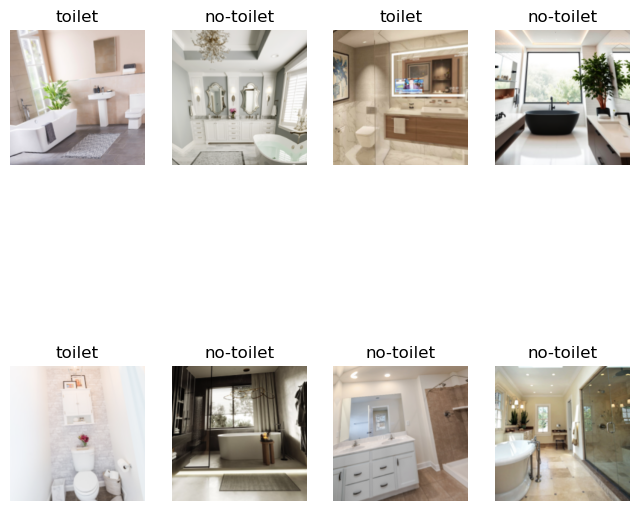

In [31]:
dls.show_batch(max_n=8, figsize=(8,8))

In [35]:
learn = vision_learner(
    dls,
    resnet34,
    metrics=accuracy
)

In [39]:
learn.fine_tune(5)

epoch,train_loss,valid_loss,accuracy,time
0,1.274996,1.744821,0.522727,00:15


epoch,train_loss,valid_loss,accuracy,time
0,1.378430,1.339679,0.500000,00:23
1,1.166955,1.288922,0.590909,00:32
2,0.993193,1.020113,0.613636,00:31
3,0.891425,0.940335,0.704545,00:31
4,0.793766,0.896917,0.727273,00:32


<Axes: title={'center': 'learning curve'}, xlabel='steps', ylabel='loss'>

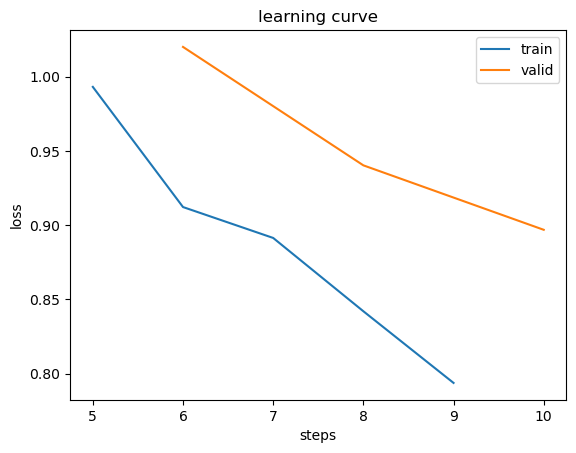

In [41]:
learn.recorder.plot_loss()

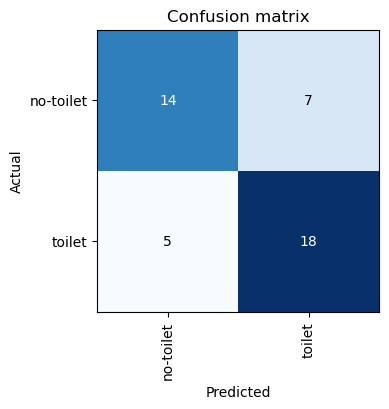

In [43]:
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(figsize=(4,4))

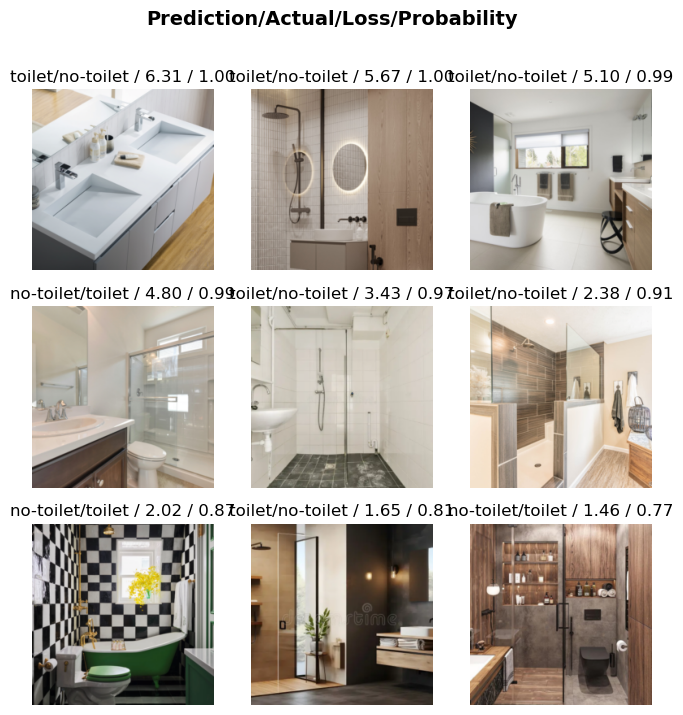

In [45]:
interp.plot_top_losses(9, figsize=(8,8))

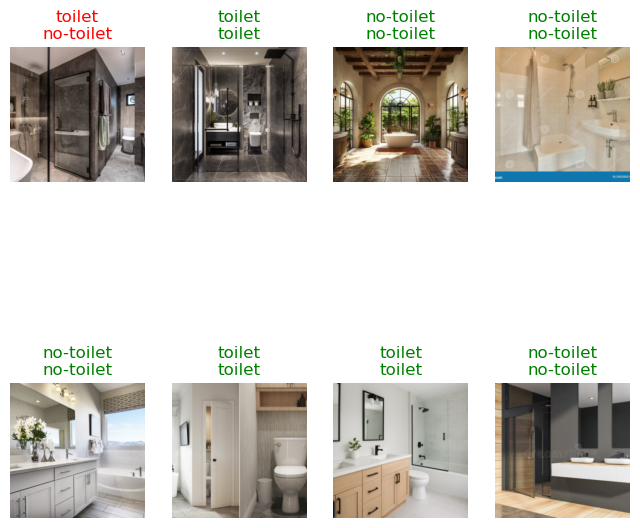

In [47]:
learn.show_results(max_n=8, figsize=(8,8))